In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [3]:
start = -7
end = 7
n = 300
batch_size = 16

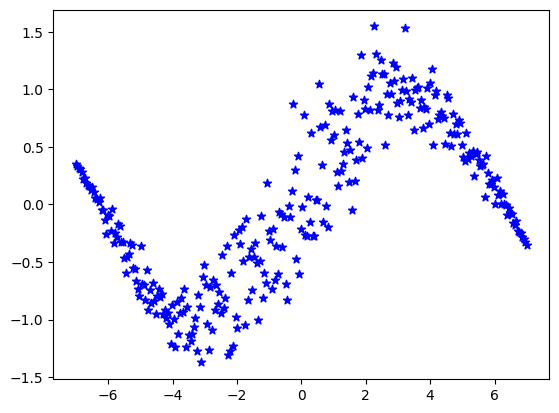

In [4]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

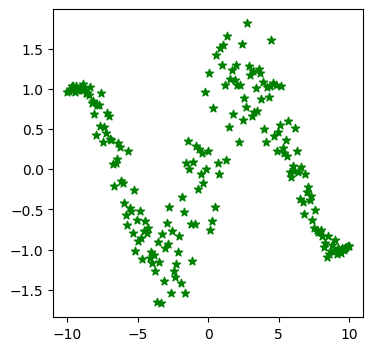

In [5]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

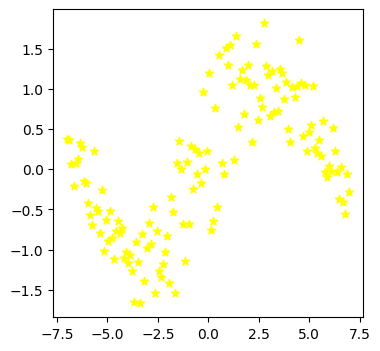

In [6]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


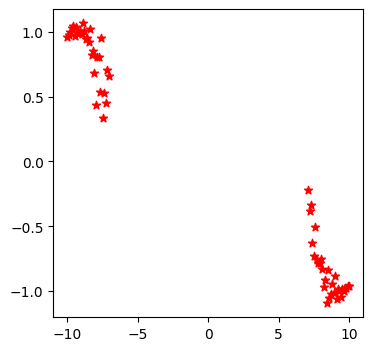

In [7]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [8]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
modelSamples = 50

In [10]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet, self).__init__()
        self.hidden_size = 35

        # We only have 1 input feature
        self.b1 = nn.Linear(1, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.mu = nn.Linear(self.hidden_size, 1)
        self.var = nn.Linear(self.hidden_size, 1)

    def forward(self, x):

        h = torch.tanh(self.b1(x))
        h = torch.tanh(self.b2(h))

        input_noise = torch.normal(0, 1, size=(x.shape[0], self.hidden_size))

        t           = torch.tanh(self.t1(input_noise))
        t           = torch.tanh(self.t2(t))
        prod        = torch.multiply(t,h)

        mu = self.mu(prod)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(prod))
        return mu, var


def make_plot_dpo(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()



In [11]:
#Plot function for Out of Distribution Data
def make_plot_dpo_oodd(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test_oodd)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_oodd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.5)
    plt.show()

In [12]:
#Plot function for In Distribution Data
def make_plot_dpo_idd(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test_idd)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_idd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.5)
    plt.show()

In [13]:
net = DeepONet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

DeepONet(
  (b1): Linear(in_features=1, out_features=35, bias=True)
  (b2): Linear(in_features=35, out_features=35, bias=True)
  (t1): Linear(in_features=35, out_features=35, bias=True)
  (t2): Linear(in_features=35, out_features=35, bias=True)
  (mu): Linear(in_features=35, out_features=1, bias=True)
  (var): Linear(in_features=35, out_features=1, bias=True)
)
Params: 3922


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
net.to(device);

In [15]:
def MLE_dopnn():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [16]:
def MLE_dopnn_idd():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo_idd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [17]:
def MLE_dopnn_oodd():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo_oodd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


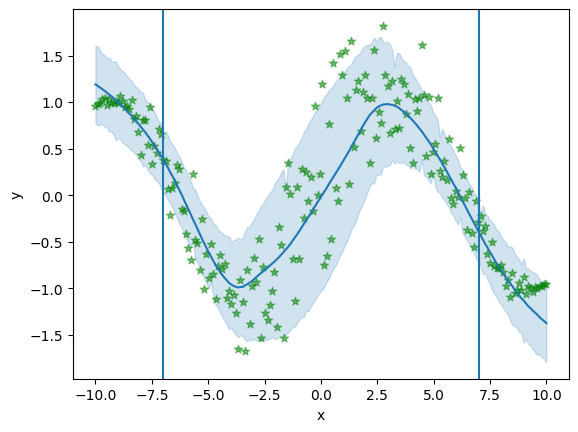

Epoch 149 | batch train loss: -1.2335679531097412 | test loss: 0.28068710290468657
Epoch 149 |batch train mse:0.03352213278412819| test mse:0.14923010709194037


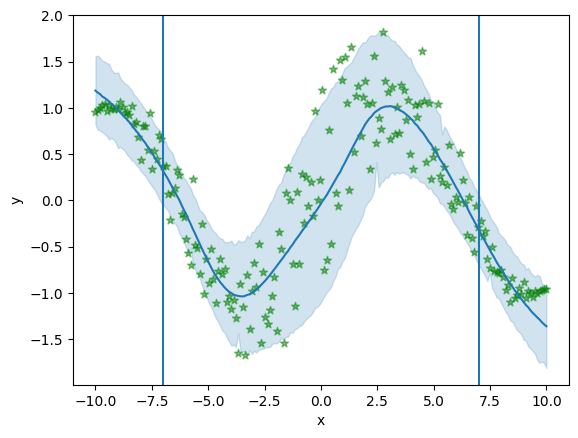

Epoch 149 | batch train loss: -1.0743019580841064 | test loss: 0.20995390988313234
Epoch 149 |batch train mse:0.08208457380533218| test mse:0.1416588700734652


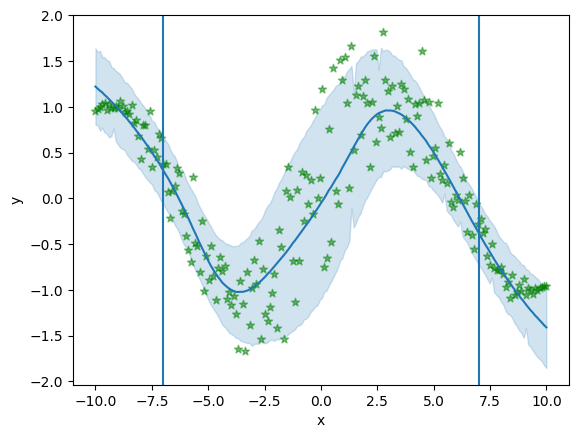

Epoch 149 | batch train loss: -1.1980618238449097 | test loss: 0.1990733089355322
Epoch 149 |batch train mse:0.04770571365952492| test mse:0.14687786480555168


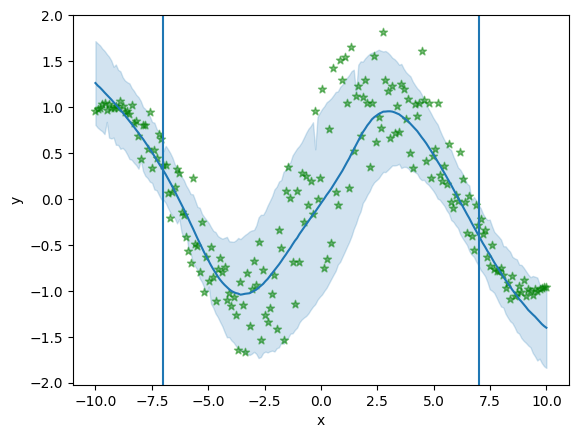

Epoch 149 | batch train loss: -0.6438646912574768 | test loss: 0.21248836815357208
Epoch 149 |batch train mse:0.14818774163722992| test mse:0.14325566360583672


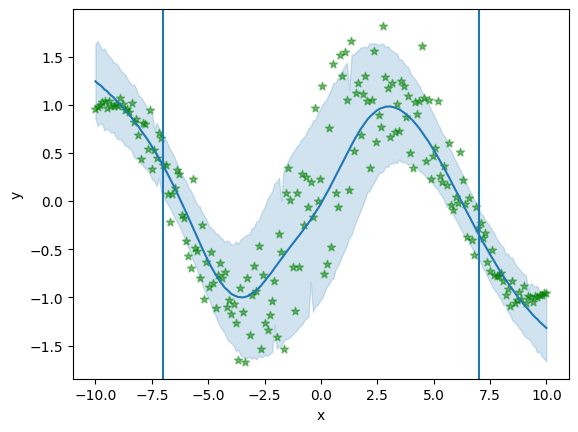

Epoch 149 | batch train loss: -1.3609824180603027 | test loss: 0.11660876526282384
Epoch 149 |batch train mse:0.0416388101875782| test mse:0.14310374483466148


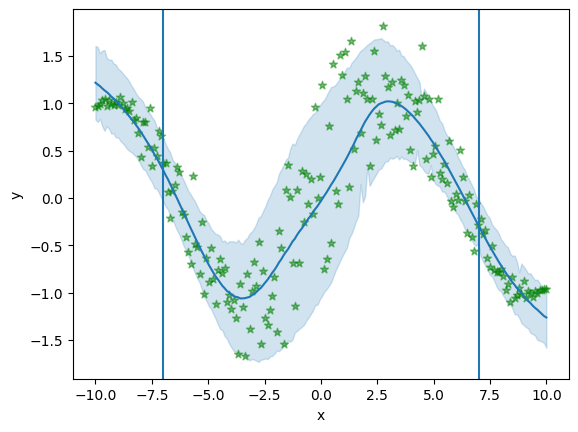

Epoch 149 | batch train loss: -1.2466551065444946 | test loss: 0.22280534184896028
Epoch 149 |batch train mse:0.03656741976737976| test mse:0.14300604508473322


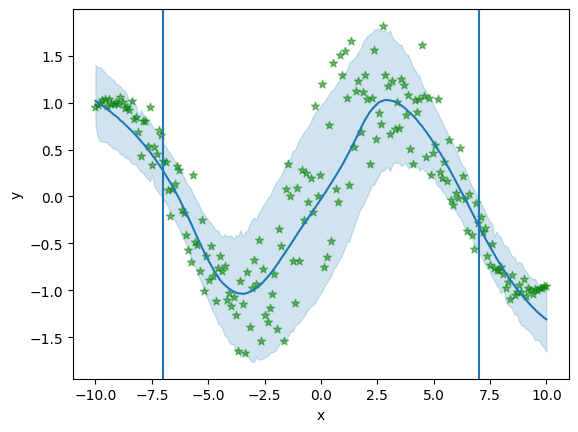

Epoch 149 | batch train loss: -0.7665861248970032 | test loss: 0.17349595977709845
Epoch 149 |batch train mse:0.1263698786497116| test mse:0.14290089074235696


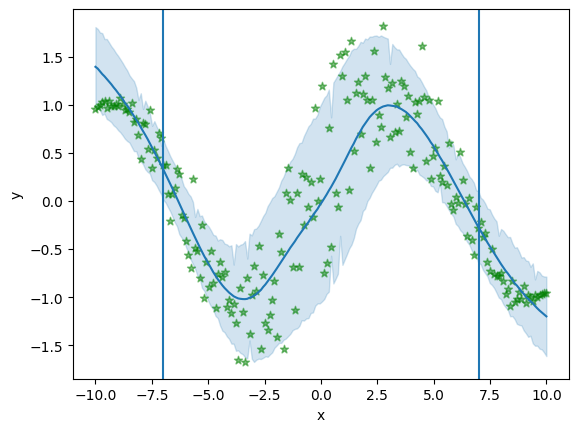

Epoch 149 | batch train loss: -0.873620331287384 | test loss: 0.45493103563785553
Epoch 149 |batch train mse:0.08379881829023361| test mse:0.15379067739615074


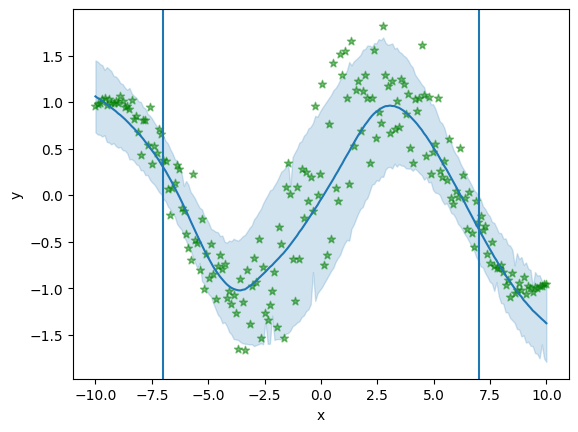

Epoch 149 | batch train loss: -1.204886555671692 | test loss: 0.2614016647522266
Epoch 149 |batch train mse:0.0802326425909996| test mse:0.14817052850356469


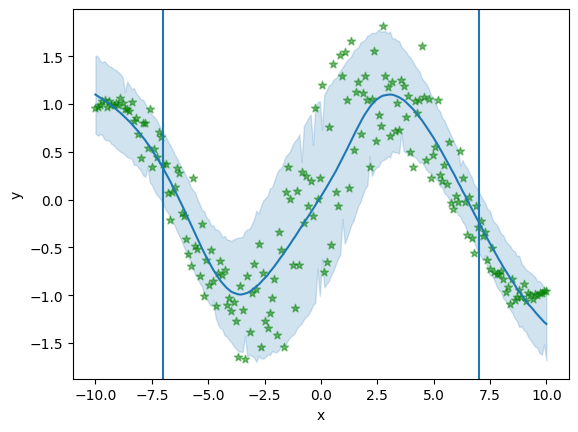

Epoch 149 | batch train loss: -1.187196969985962 | test loss: 0.08276967646983954
Epoch 149 |batch train mse:0.058791130781173706| test mse:0.13967338032447374


In [18]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

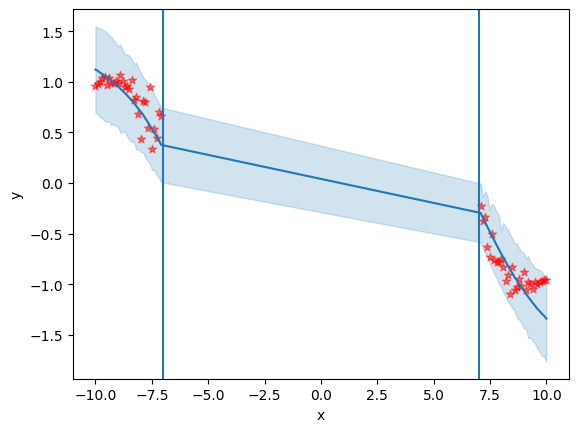

Epoch 149 | batch train loss: -1.5923829078674316 | test loss: -0.36452321894466877
Epoch 149 |batch train mse:0.023465439677238464| test mse:0.03876123810186982


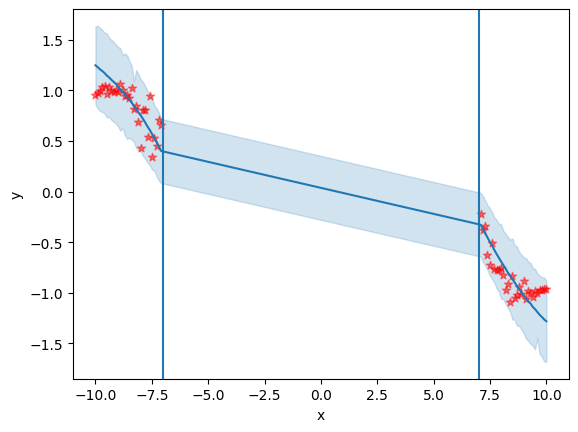

Epoch 149 | batch train loss: -1.5669631958007812 | test loss: -0.9890607297420502
Epoch 149 |batch train mse:0.03939850255846977| test mse:0.026270486880093813


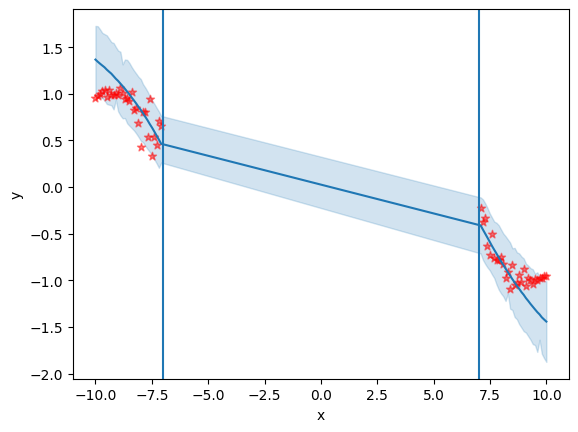

Epoch 149 | batch train loss: -1.4564357995986938 | test loss: -0.42019446939229965
Epoch 149 |batch train mse:0.024551941081881523| test mse:0.03764781169593334


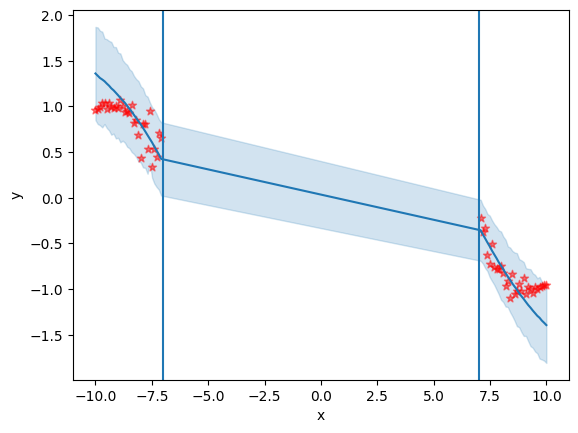

Epoch 149 | batch train loss: -1.281826138496399 | test loss: 0.5218881964683533
Epoch 149 |batch train mse:0.026187913492321968| test mse:0.05948079563677311


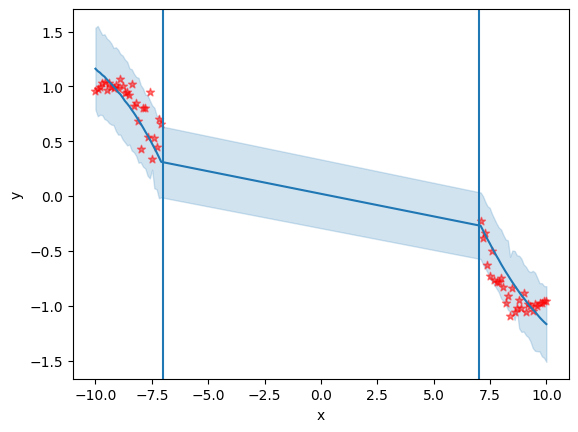

Epoch 149 | batch train loss: -1.1518750190734863 | test loss: -1.0353902205824852
Epoch 149 |batch train mse:0.11553650349378586| test mse:0.02534389728680253


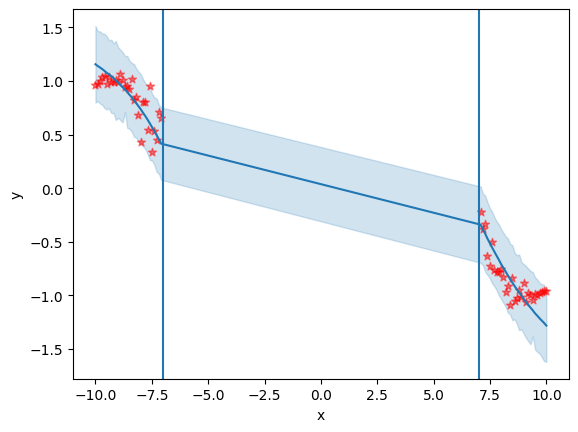

Epoch 149 | batch train loss: -0.8387593626976013 | test loss: -1.1461950242519379
Epoch 149 |batch train mse:0.16777360439300537| test mse:0.02312780125066638


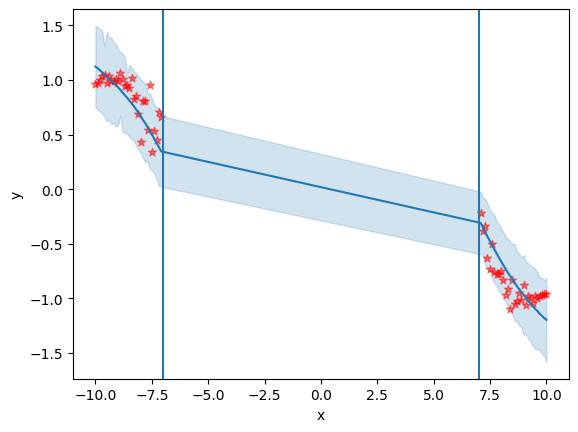

Epoch 149 | batch train loss: -1.275974154472351 | test loss: -1.2431523203849792
Epoch 149 |batch train mse:0.048859234899282455| test mse:0.021188655402511358


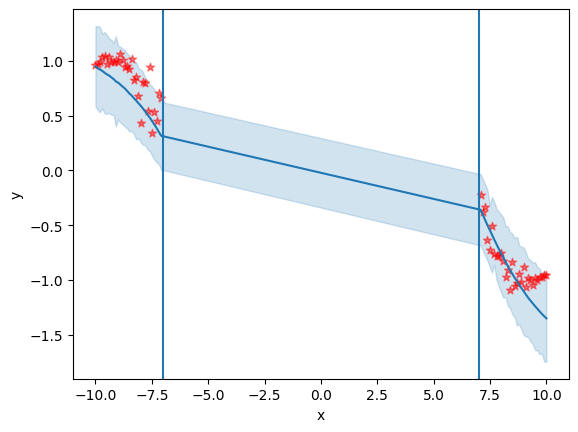

Epoch 149 | batch train loss: -0.9542579650878906 | test loss: -0.6095366217195988
Epoch 149 |batch train mse:0.06340362876653671| test mse:0.03386096889153123


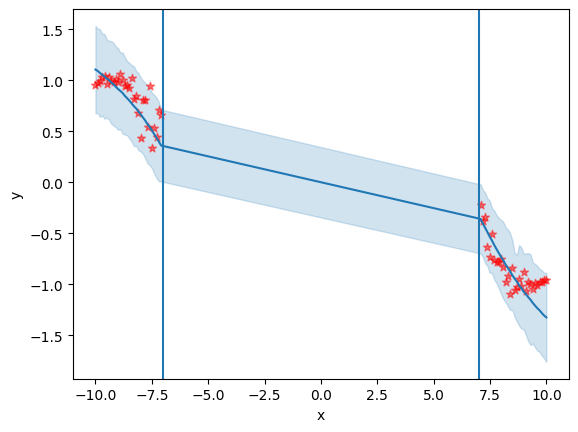

Epoch 149 | batch train loss: -1.2117503881454468 | test loss: -1.1408964097499847
Epoch 149 |batch train mse:0.023273387923836708| test mse:0.02323377411812544


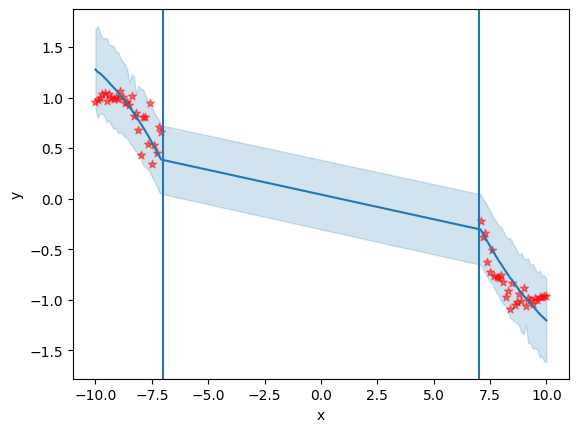

Epoch 149 | batch train loss: -1.1161149740219116 | test loss: -0.7814103662967682
Epoch 149 |batch train mse:0.0833265408873558| test mse:0.030436926521360874


In [19]:
train_losses_oodd=[]
test_losses_oodd=[]
errors_train_oodd=[]
errors_test_oodd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)

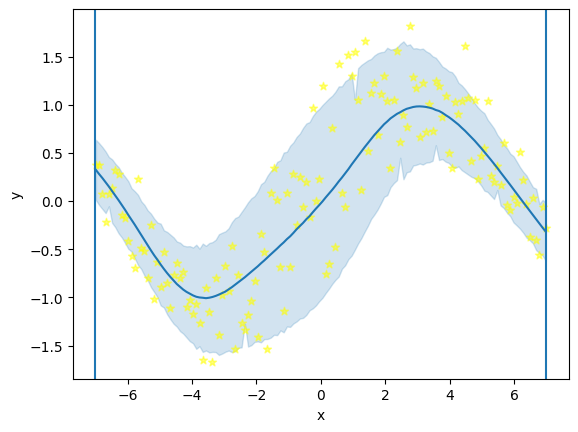

Epoch 149 | batch train loss: -0.9794062972068787 | test loss: 0.5472445173396004
Epoch 149 |batch train mse:0.07289198786020279| test mse:0.19293733768992954


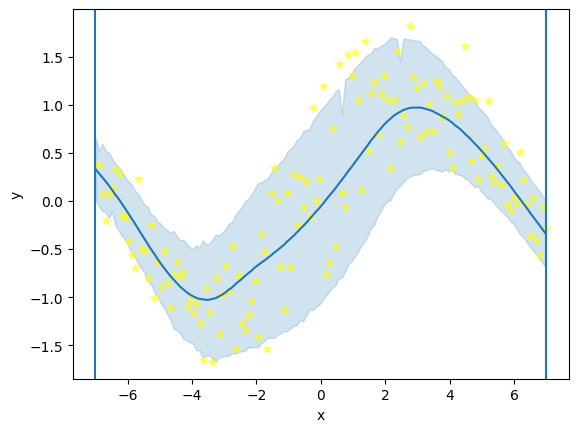

Epoch 149 | batch train loss: -0.8157560229301453 | test loss: 0.7889917625321282
Epoch 149 |batch train mse:0.1023339033126831| test mse:0.1956101813250118


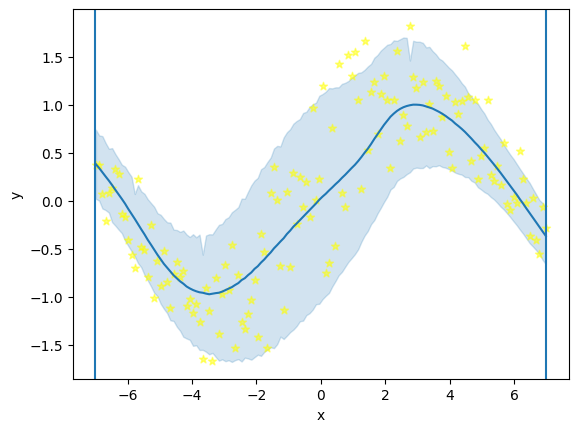

Epoch 149 | batch train loss: -0.992914617061615 | test loss: 0.5943061339979371
Epoch 149 |batch train mse:0.06941350549459457| test mse:0.18813836988475588


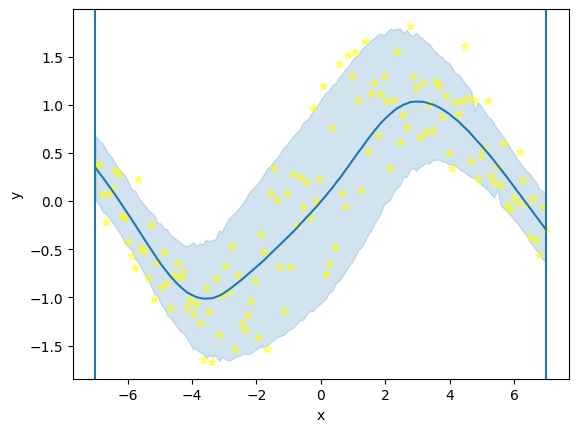

Epoch 149 | batch train loss: -1.2773126363754272 | test loss: 0.5503250021073554
Epoch 149 |batch train mse:0.03680144250392914| test mse:0.18611952993604872


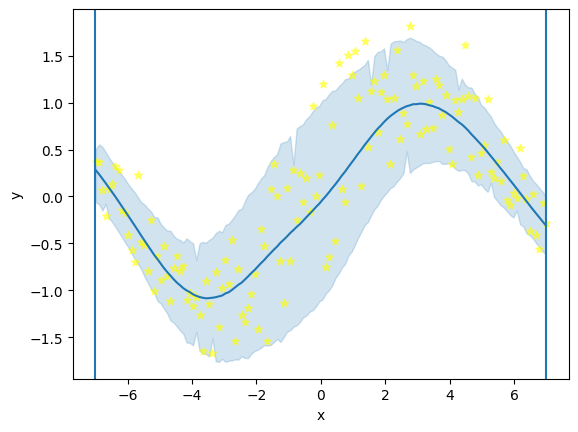

Epoch 149 | batch train loss: -0.9782808423042297 | test loss: 0.5101887273291746
Epoch 149 |batch train mse:0.05536952242255211| test mse:0.19077246139446893


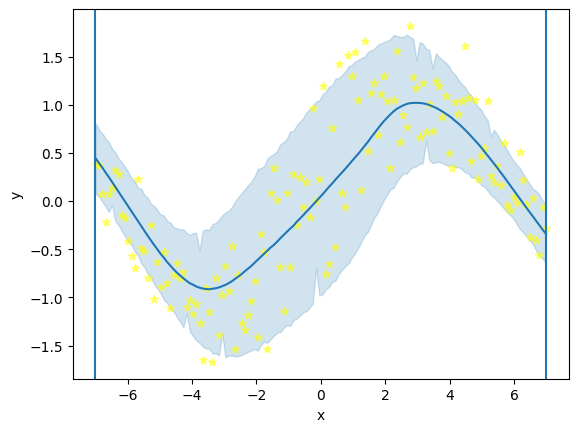

Epoch 149 | batch train loss: -1.2306686639785767 | test loss: 0.7362481753031412
Epoch 149 |batch train mse:0.05714419111609459| test mse:0.2022480997774336


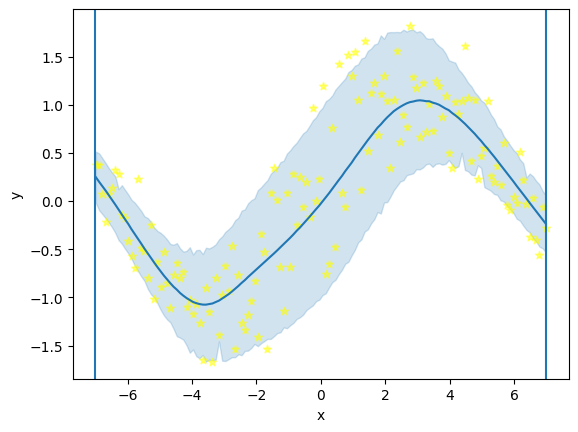

Epoch 149 | batch train loss: -1.4024910926818848 | test loss: 0.46005381395419437
Epoch 149 |batch train mse:0.020035380497574806| test mse:0.18972051640351614


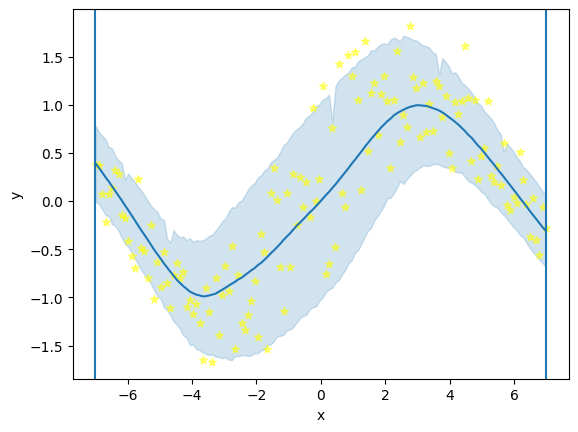

Epoch 149 | batch train loss: -1.4663971662521362 | test loss: 0.586817296842734
Epoch 149 |batch train mse:0.021050473675131798| test mse:0.1985619010196792


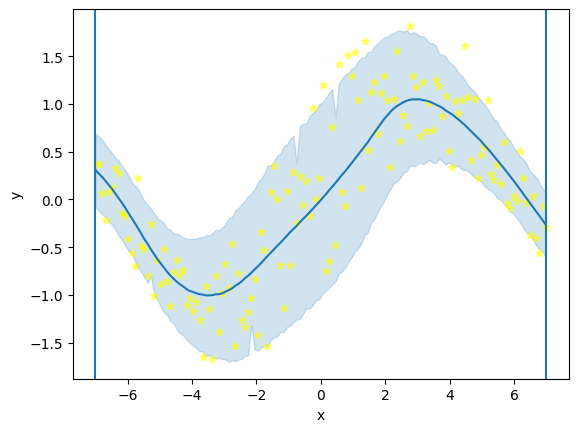

Epoch 149 | batch train loss: -0.8543612957000732 | test loss: 0.6342201249467002
Epoch 149 |batch train mse:0.10313776135444641| test mse:0.19391175028350618


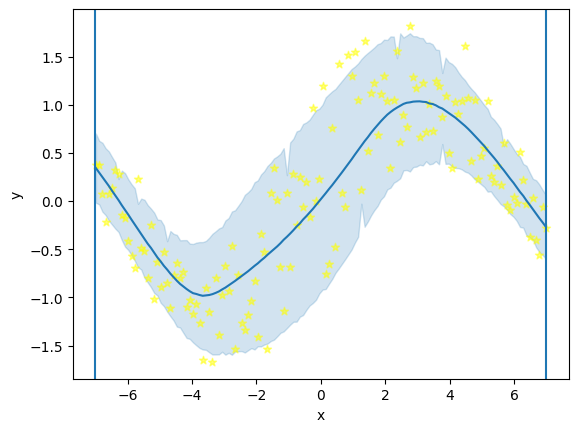

Epoch 149 | batch train loss: -1.0951988697052002 | test loss: 0.6657592306534449
Epoch 149 |batch train mse:0.03976956009864807| test mse:0.19593668232361475


In [20]:
train_losses_idd=[]
test_losses_idd=[]
errors_train_idd=[]
errors_test_idd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)
  errors_train_idd.append(mse_tr)
  errors_test_idd.append(mse_test)

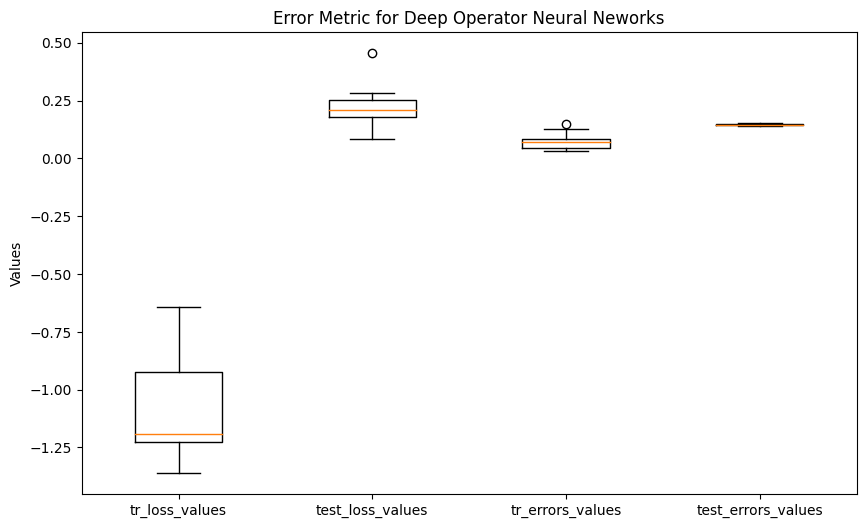

In [21]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metric for Deep Operator Neural Neworks')

# Show the plot
plt.show()


In [22]:

mean_gaus_train_loss = np.mean(tr_loss_values)
std_dev_gaus_train_loss = np.std(tr_loss_values)

mean_gaus_test_loss = np.mean(test_loss_values)
std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_errors_values)
std_dev_mse_train = np.std(tr_errors_values)

mean_mse_test = np.mean(test_errors_values)
std_dev_mse_test = np.std(test_errors_values)

print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of Gausiann Training Loss of 10 runs  -1.0789723932743072
Standard Deviation of Gausiann Training Loss of 10 runs  0.22414087905885752
Mean of Gausiann Testing Loss of 10 runs  0.2214215133625727
Standard Deviation of Gausiann Testing Loss of 10 runs  0.09636238195574491
Mean of MSE Training of 10 runs  0.07388988621532917
Standard Deviation of MSE Training of 10 runs  0.036682596086006956
Mean of MSE Testing of 10 runs  0.14516677724627347
Standard Deviation of MSE Testing of 10 runs  0.00403765936100341


In [23]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_donn.csv', index=True)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.233568      0.280687                     0.033522   
2       -1.074302      0.209954                     0.082085   
3       -1.198062      0.199073                     0.047706   
4       -0.643865      0.212488                     0.148188   
5       -1.360982      0.116609                     0.041639   
6       -1.246655      0.222805                     0.036567   
7       -0.766586      0.173496                     0.126370   
8       -0.873620      0.454931                     0.083799   
9       -1.204887      0.261402                     0.080233   
10      -1.187197      0.082770                     0.058791   

    Mean Squared Testing Error  
1                     0.149230  
2                     0.141659  
3                     0.146878  
4                     0.143256  
5                     0.143104  
6                     0.143006  
7                     0.142901  
8                     0.153791 

In [24]:
print(test_errors_values)

[0.14923010709194037, 0.1416588700734652, 0.14687786480555168, 0.14325566360583672, 0.14310374483466148, 0.14300604508473322, 0.14290089074235696, 0.15379067739615074, 0.14817052850356469, 0.13967338032447374]
